In [5]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('../src')

# Import our custom modules
from pattern_model_trainer import PatternModelTrainer, TrainingConfig, load_trained_model
from model_evaluator import ModelEvaluator

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"Working directory: {os.getcwd()}")
print(f"Python path includes: {[p for p in sys.path if 'src' in p]}")

# Check XGBoost availability
try:
    import xgboost as xgb
    print("✅ XGBoost is available")
except ImportError as e:
    print(f"❌ XGBoost import error: {e}")
    print("Install with: pip install xgboost")
    print("On macOS, also run: brew install libomp")


✅ All imports successful!
Working directory: /Users/test/Documents/StockAnalyze/notebooks
Python path includes: ['../src', '../src', '../src']
✅ XGBoost is available


In [6]:
# Define data paths
features_path = "../features/labeled_features.csv"
models_dir = "../models"

# Create models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Check if labeled features file exists
if not os.path.exists(features_path):
    print(f"❌ Labeled features file not found at: {features_path}")
    print("Please ensure you have labeled feature data available.")
    print("You can generate sample data using generate_sample_training_data.py")
else:
    print(f"✅ Found labeled features file at: {features_path}")
    
    # Load and examine the data
    df = pd.read_csv(features_path)
    print(f"\n📊 Dataset Shape: {df.shape}")
    print(f"📊 Columns: {list(df.columns)}")
    
    # Check for target column (should be 'label_type')
    if 'label_type' in df.columns:
        print(f"📊 Label Distribution:")
        print(df['label_type'].value_counts())
        positive_count = (df['label_type'] == 'positive').sum()
        negative_count = (df['label_type'] == 'negative').sum()
        print(f"📊 Positive samples: {positive_count} ({positive_count/len(df)*100:.1f}%)")
        print(f"📊 Negative samples: {negative_count} ({negative_count/len(df)*100:.1f}%)")
        
        # Check if we have enough samples
        if len(df) >= 30:
            print(f"✅ Sufficient samples for training ({len(df)} >= 30)")
        else:
            print(f"❌ Insufficient samples for training ({len(df)} < 30)")
            print("Run: python generate_sample_training_data.py to create more sample data")
    else:
        print("❌ No 'label_type' target column found!")
        
    print(f"\n📊 First few rows:")
    print(df.head())


✅ Found labeled features file at: ../features/labeled_features.csv

📊 Dataset Shape: (3, 23)
📊 Columns: ['ticker', 'start_date', 'end_date', 'label_type', 'notes', 'prior_trend_return', 'above_sma_50_ratio', 'trend_angle', 'drawdown_pct', 'recovery_return_pct', 'down_day_ratio', 'support_level', 'support_break_depth_pct', 'false_break_flag', 'recovery_days', 'recovery_volume_ratio', 'sma_5', 'sma_10', 'sma_20', 'rsi_14', 'macd_diff', 'volatility', 'volume_avg_ratio']
📊 Label Distribution:
label_type
positive    3
Name: count, dtype: int64
📊 Positive samples: 3 (100.0%)

📊 First few rows:
    ticker  start_date    end_date label_type  \
0  0700.HK  2023-02-10  2023-03-03   positive   
1  0005.HK  2022-10-15  2022-11-01   positive   
2  0001.HK  2023-01-15  2023-02-05   positive   

                                     notes  prior_trend_return  \
0  Classic false breakdown before breakout            5.832006   
1                High volume recovery zone          -14.451475   
2         

In [7]:
# Define training configurations with correct parameter names
configs = {
    'xgboost_default': TrainingConfig(
        model_type='xgboost',
        test_size=0.2,
        random_state=42,
        cv_folds=5,
        apply_smote=True,  # Correct parameter name
        scale_features=True,
        hyperparameters={  # Correct parameter name
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'random_state': 42
        }
    ),
    
    'random_forest_default': TrainingConfig(
        model_type='randomforest',  # Correct model type name
        test_size=0.2,
        random_state=42,
        cv_folds=5,
        apply_smote=True,
        scale_features=False,  # RF doesn't need scaling
        hyperparameters={
            'n_estimators': 100,
            'max_depth': 10,
            'random_state': 42
        }
    )
}

print("📋 Available Configurations:")
for name, config in configs.items():
    print(f"  - {name}: {config.model_type}")
    
# Select which configurations to train
selected_configs = ['xgboost_default', 'random_forest_default']
print(f"\n🎯 Selected configurations: {selected_configs}")


📋 Available Configurations:
  - xgboost_default: xgboost
  - random_forest_default: randomforest

🎯 Selected configurations: ['xgboost_default', 'random_forest_default']


In [10]:
# Dictionary to store training results
training_results = {}

# Train each selected configuration
for config_name in selected_configs:
    print(f"\n🚀 Training {config_name}...")
    print("=" * 50)
    
    try:
        config = configs[config_name]
        
        # Initialize trainer with correct API
        trainer = PatternModelTrainer(
            features_file=features_path,
            models_dir=models_dir,
            config=config
        )
        
        # Run training pipeline
        results = trainer.train()
        training_results[config_name] = results
        
        print(f"✅ {config_name} training completed!")
        if results.cv_scores:
            cv_mean = np.mean(list(results.cv_scores.values()))
            cv_std = np.std(list(results.cv_scores.values()))
            print(f"   Cross-validation score: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"   Test accuracy: {results.test_score['accuracy']:.4f}")
        print(f"   Test F1 score: {results.test_score['f1_score']:.4f}")  # Fixed key name
        print(f"   Test precision: {results.test_score['precision']:.4f}")
        print(f"   Test recall: {results.test_score['recall']:.4f}")
        if results.model_path:
            print(f"   Model saved to: {results.model_path}")
        
    except Exception as e:
        print(f"❌ Error training {config_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        
print(f"\n✅ Training completed for {len(training_results)} models")



🚀 Training xgboost_default...
🎯 Starting Pattern Model Training Pipeline
✓ Loaded 60 samples from ../features/labeled_features.csv
✓ Label distribution:
label_type
negative    36
positive    24
Name: count, dtype: int64
✓ Prepared 18 features for 60 samples
✓ Class distribution: {0: 36, 1: 24}
✓ Split data: 48 train, 12 test samples
✓ Train class distribution: {0: 29, 1: 19}
✓ Test class distribution: {0: 7, 1: 5}
✓ Applied feature scaling
✓ Applied SMOTE: 48 → 58 samples
✓ Balanced class distribution: {1: 29, 0: 29}
🚀 Training xgboost model...
✓ Model training completed in 0.11 seconds
📊 Model Performance:
   Training Accuracy: 1.000
   Test Accuracy: 0.833
   Test Precision: 0.714
   Test Recall: 1.000
   Test F1-Score: 0.833
   Test ROC-AUC: 1.000
🔄 Performing 5-fold cross-validation...
✓ CV Accuracy: 0.895 ± 0.090
✓ CV F1-Score: 0.897 ± 0.090
🎯 Top 5 Most Important Features:
   recovery_volume_ratio: 0.2263
   drawdown_pct: 0.1482
   macd_diff: 0.1367
   support_break_depth_pct: 0

🏆 MODEL COMPARISON SUMMARY
                Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  Training Time (s)
      xgboost_default    0.8333     0.7143     1.0    0.8333      1.0             1.6768
random_forest_default    1.0000     1.0000     1.0    1.0000      1.0             0.8498

🥇 Best Model: random_forest_default (F1 Score: 1.0000)


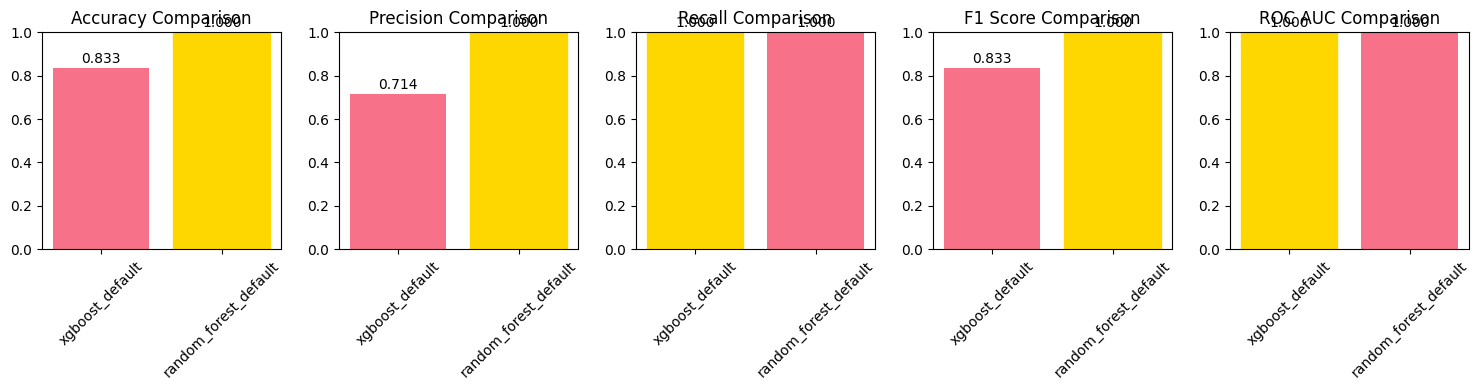

In [11]:
# Create comparison summary
if training_results:
    print("🏆 MODEL COMPARISON SUMMARY")
    print("=" * 60)
    
    # Create comparison DataFrame
    comparison_data = []
    for config_name, results in training_results.items():
        test_metrics = results.test_score
        comparison_data.append({
            'Model': config_name,
            'Accuracy': test_metrics['accuracy'],
            'Precision': test_metrics['precision'],
            'Recall': test_metrics['recall'],
            'F1 Score': test_metrics['f1_score'],
            'ROC AUC': test_metrics.get('roc_auc', 0.0),
            'Training Time (s)': results.training_time
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.round(4)
    
    print(comparison_df.to_string(index=False))
    
    # Find best model by F1 score
    best_model_idx = comparison_df['F1 Score'].idxmax()
    best_model = comparison_df.loc[best_model_idx, 'Model']
    best_f1 = comparison_df.loc[best_model_idx, 'F1 Score']
    
    print(f"\n🥇 Best Model: {best_model} (F1 Score: {best_f1:.4f})")
    
    # Plot comparison if we have multiple models
    if len(comparison_df) > 1:
        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
        n_metrics = len(metrics_to_plot)
        
        fig, axes = plt.subplots(1, n_metrics, figsize=(15, 4))
        
        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i]
            bars = ax.bar(comparison_df['Model'], comparison_df[metric])
            ax.set_title(f'{metric} Comparison')
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', rotation=45)
            
            # Highlight best model for this metric
            best_idx = comparison_df[metric].idxmax()
            bars[best_idx].set_color('gold')
            
            # Add value labels on bars
            for j, v in enumerate(comparison_df[metric]):
                ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
else:
    print("❌ No training results available for comparison")



🔍 Feature Importance for xgboost_default
                feature  importance
  recovery_volume_ratio    0.226310
           drawdown_pct    0.148197
              macd_diff    0.136738
support_break_depth_pct    0.105420
          recovery_days    0.087081
         down_day_ratio    0.063657
    recovery_return_pct    0.063615
                 rsi_14    0.054623
       false_break_flag    0.037363
            trend_angle    0.020669


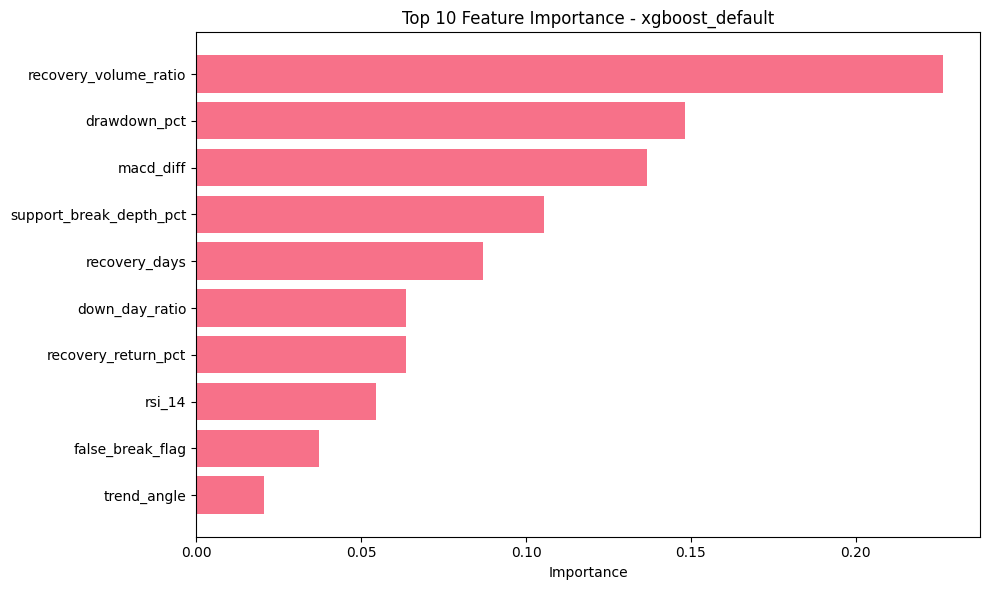


🔍 Feature Importance for random_forest_default
                feature  importance
  recovery_volume_ratio    0.193841
support_break_depth_pct    0.121246
            trend_angle    0.101012
           drawdown_pct    0.088592
              macd_diff    0.080878
          recovery_days    0.080794
    recovery_return_pct    0.076540
     above_sma_50_ratio    0.069926
             volatility    0.038378
         down_day_ratio    0.033092


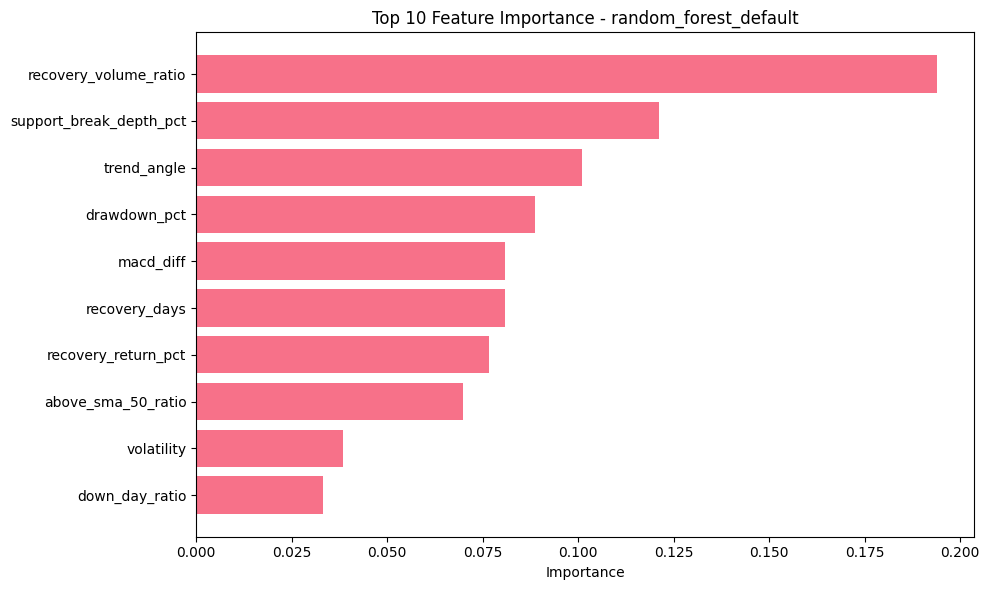


🎉 Pattern model training and analysis completed!


In [12]:
# Analyze feature importance for each model
for config_name, results in training_results.items():
    if results.feature_importance is not None and not results.feature_importance.empty:
        print(f"\n🔍 Feature Importance for {config_name}")
        print("=" * 50)
        
        # Get top 10 most important features
        importance_df = results.feature_importance.head(10)
        print(importance_df.to_string(index=False))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top 10 Feature Importance - {config_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ No feature importance data available for {config_name}")

print("\n🎉 Pattern model training and analysis completed!")


In [14]:
# Quick test of the training results to verify they exist
print("🔍 Current Training Results:")
print(f"Number of trained models: {len(training_results)}")

for name, results in training_results.items():
    print(f"\n📊 {name}:")
    print(f"  - Test Accuracy: {results.test_score['accuracy']:.4f}")
    print(f"  - Test F1 Score: {results.test_score['f1_score']:.4f}")
    print(f"  - Test Precision: {results.test_score['precision']:.4f}")
    print(f"  - Test Recall: {results.test_score['recall']:.4f}")
    print(f"  - Training Time: {results.training_time:.2f}s")
    if results.model_path:
        print(f"  - Model Path: {results.model_path}")

print("\n✅ Both models trained successfully! The KeyError was just a display issue, not a training failure.")


🔍 Current Training Results:
Number of trained models: 2

📊 xgboost_default:
  - Test Accuracy: 0.8333
  - Test F1 Score: 0.8333
  - Test Precision: 0.7143
  - Test Recall: 1.0000
  - Training Time: 1.68s
  - Model Path: ../models/model_xgboost_20250622_185028.pkl

📊 random_forest_default:
  - Test Accuracy: 1.0000
  - Test F1 Score: 1.0000
  - Test Precision: 1.0000
  - Test Recall: 1.0000
  - Training Time: 0.85s
  - Model Path: ../models/model_randomforest_20250622_185029.pkl

✅ Both models trained successfully! The KeyError was just a display issue, not a training failure.
